<a href="https://colab.research.google.com/github/Sebastien01/images_classification/blob/master/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_path = '/content/drive/MyDrive/Data/seg_train'
test_path = '/content/drive/MyDrive/Data/seg_test'
pred_path = '/content/drive/MyDrive/Data/seg_pred'

IMG_SIZE = (160,160)
BATCH_SIZE = 32

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [5]:
train_dataset = image_dataset_from_directory(train_path,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             label_mode='categorical')

Found 11784 files belonging to 6 classes.


In [6]:
validation_dataset = image_dataset_from_directory(test_path,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  label_mode='categorical')

Found 2961 files belonging to 6 classes.


In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
pred_dataset = image_dataset_from_directory(pred_path,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,
                                            label_mode='categorical')

Found 7237 files belonging to 1 classes.


In [9]:
class_names = train_dataset.class_names

In [10]:
def plot_class_distribution(dataset,ds_name):
  class_array = np.concatenate(list(dataset.map(lambda image,label: label).as_numpy_iterator()),axis=0)
  class_count = [class_array[:,i].sum() for i in range(class_array.shape[1])]
  sns.barplot(y=class_count,x=class_names)
  plt.title(f'{ds_name} distribution')

In [ ]:
# plt.figure(figsize=(20,5))
# ax = plt.subplot(1,3,1)
# plot_class_distribution(train_dataset,'train_set')
# ax = plt.subplot(1,3,2)
# plot_class_distribution(validation_dataset,'validation_set')
# ax = plt.subplot(1,3,3)
# plot_class_distribution(test_dataset,'test_set')

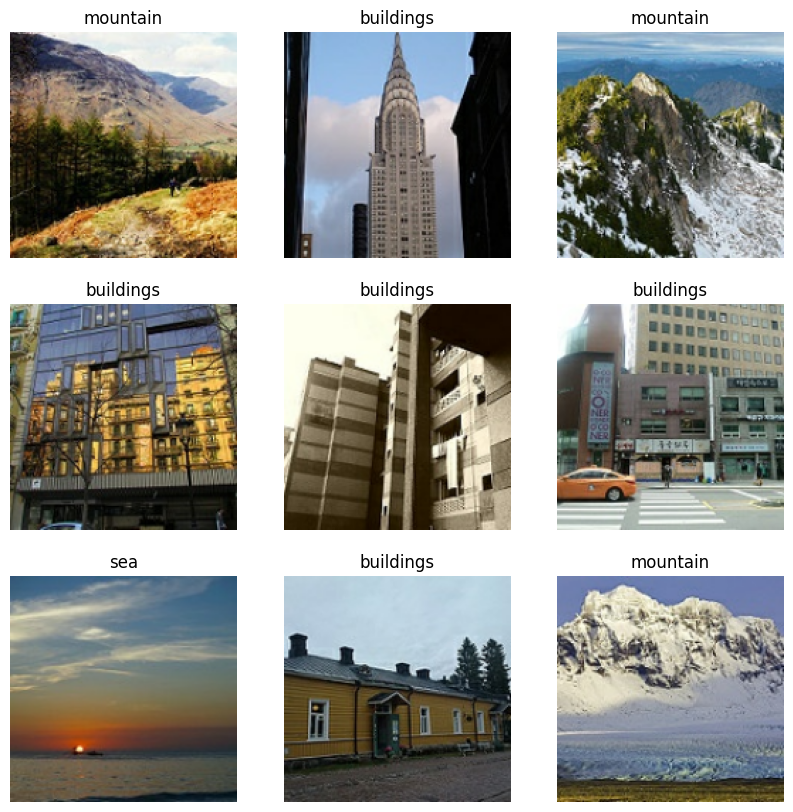

In [12]:
images,labels = next(iter(validation_dataset))
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(class_names[labels[i].numpy().argmax()])
  plt.axis("off")

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
pred_dataset = pred_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
preprocess_input = tf.keras.applications.xception.preprocess_input

In [15]:

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.xception.Xception(input_shape=IMG_SHAPE,
                                                      include_top=False,
                                                      weights='imagenet')

83683744/83683744 [==============================] - 0s 0us/step


In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [17]:
base_model.trainable = False

In [18]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 79, 79, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [20]:
prediction_layer = tf.keras.layers.Dense(6,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 6)


In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(test_dataset)

18/18 [==============================] - 4s 88ms/step - loss: 1.8982 - categorical_accuracy: 0.1771


In [25]:
print('Baseline loss:', loss0)
print('Baseline accuracy:', accuracy0)

Baseline loss: 1.8981965780258179
Baseline accuracy: 0.1770833283662796


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
369/369 [==============================] - 999s 3s/step - loss: 0.9841 - categorical_accuracy: 0.6892 - val_loss: 0.9244 - val_categorical_accuracy: 0.7501
Epoch 2/10
369/369 [==============================] - 29s 78ms/step - loss: 0.4587 - categorical_accuracy: 0.8844 - val_loss: 0.6828 - val_categorical_accuracy: 0.7623
Epoch 3/10
369/369 [==============================] - 30s 80ms/step - loss: 0.3476 - categorical_accuracy: 0.9014 - val_loss: 0.5845 - val_categorical_accuracy: 0.7748
Epoch 4/10
369/369 [==============================] - 29s 78ms/step - loss: 0.3065 - categorical_accuracy: 0.9044 - val_loss: 0.5260 - val_categorical_accuracy: 0.7874
Epoch 5/10
369/369 [==============================] - 29s 78ms/step - loss: 0.2739 - categorical_accuracy: 0.9160 - val_loss: 0.4912 - val_categorical_accuracy: 0.8013
Epoch 6/10
369/369 [==============================] - 29s 78ms/step - loss: 0.2593 - categorical_accuracy: 0.9154 - val_loss: 0.4697 - val_categorical_accuracy: 

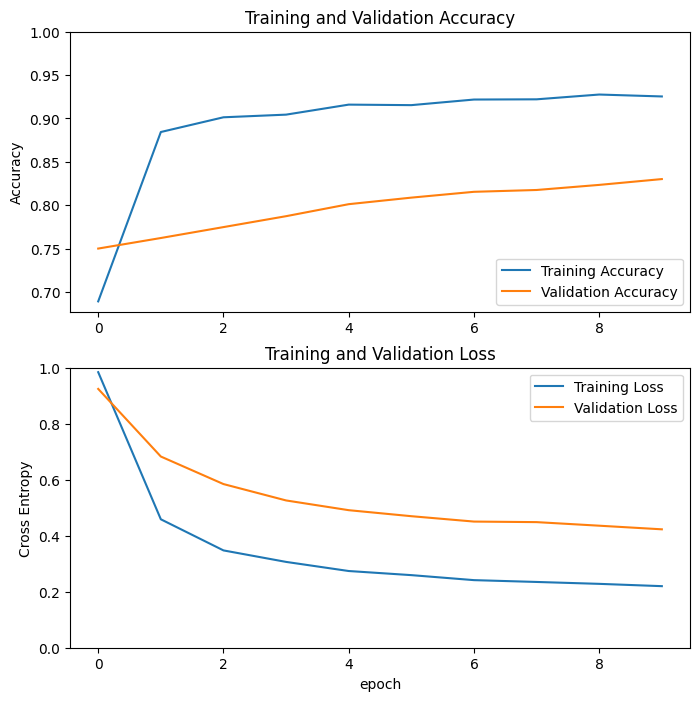

In [27]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
base_model.trainable = True

In [29]:

print("Number of layers in the base model: ", len(base_model.layers))


fine_tune_at = 100


for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  132


In [30]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [31]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=5, restore_best_weights=True,monitor='val_categorical_accuracy')

In [32]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[es])

Epoch 10/20
369/369 [==============================] - 55s 119ms/step - loss: 0.1899 - categorical_accuracy: 0.9354 - val_loss: 0.3901 - val_categorical_accuracy: 0.8486
Epoch 11/20
369/369 [==============================] - 42s 115ms/step - loss: 0.1529 - categorical_accuracy: 0.9483 - val_loss: 0.3663 - val_categorical_accuracy: 0.8574
Epoch 12/20
369/369 [==============================] - 42s 114ms/step - loss: 0.1329 - categorical_accuracy: 0.9539 - val_loss: 0.3732 - val_categorical_accuracy: 0.8608
Epoch 13/20
369/369 [==============================] - 42s 114ms/step - loss: 0.1140 - categorical_accuracy: 0.9606 - val_loss: 0.3639 - val_categorical_accuracy: 0.8713
Epoch 14/20
369/369 [==============================] - 43s 116ms/step - loss: 0.1014 - categorical_accuracy: 0.9659 - val_loss: 0.3581 - val_categorical_accuracy: 0.8763
Epoch 15/20
369/369 [==============================] - 43s 116ms/step - loss: 0.0884 - categorical_accuracy: 0.9696 - val_loss: 0.3841 - val_categoric

In [33]:
acc += history_fine.history['categorical_accuracy']
val_acc += history_fine.history['val_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

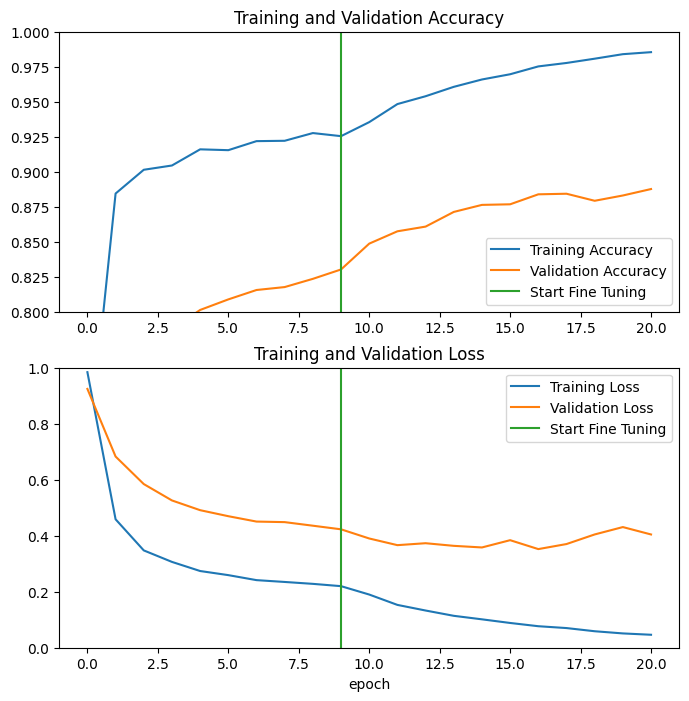

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
loss, accuracy = model.evaluate(test_dataset)

18/18 [==============================] - 1s 66ms/step - loss: 0.4777 - categorical_accuracy: 0.8785


In [53]:
from tensorflow.keras.models import save_model

In [55]:
save_model(model,'/content/drive/MyDrive/Data/final')